In [1076]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression
from reinhard import Reinhard

import importlib
import wavelet
importlib.reload(wavelet)
from wavelet import Wavelet

In [1077]:
def convert_OD(image, I_0=255):
    image = np.clip(image.astype(np.float64), 1, None)
    od_image = -np.log10(image / I_0)
    return od_image


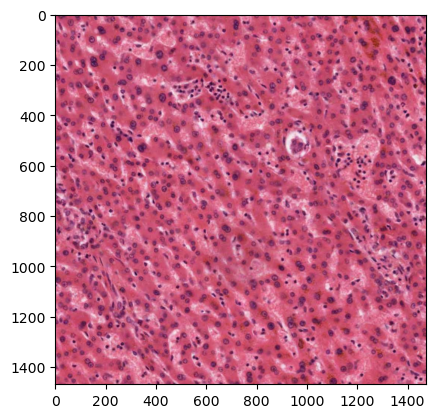

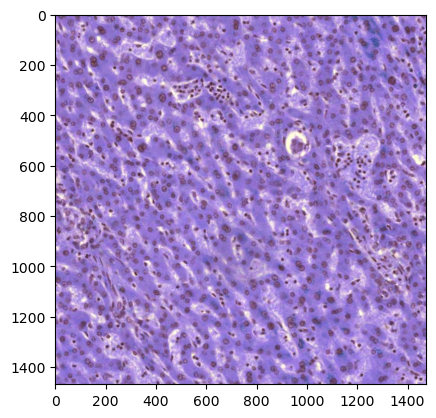

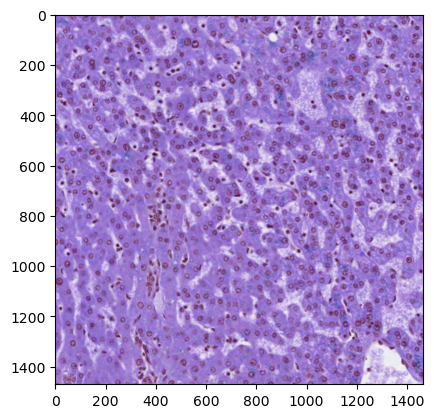

False
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convert_OD', 'deconv_stains', 'estimate_stain_matrix', 'extract_individual_stains', 'image_diff', 'prep_3_channel', 'prepare_ica', 'recon_and_vis', 'reconstruct', 'select_best_bands', 'visualise', 'wavelet_decomposition']


In [1078]:
image_path = "og.png"
target_image_path = "target.png"

image = cv2.imread(image_path)
target_image = cv2.imread(target_image_path)

normalizer = Reinhard(target_image)
result = normalizer.reinhard_normalization(image)

plt.imshow(image_rgb)
plt.show()
plt.imshow(result)
plt.show()
plt.imshow(target_image)
plt.show()



In [1079]:
def wavelet_decomposition(od_image, wavelet='haar', levels=5):
    all_bands = []
    for i in range(3):
        channel = od_image[:,:,i]
        channel_bands = []

        coeffs = pywt.wavedec2(channel, wavelet, level=levels)
        approximation = coeffs[0]
        channel_bands.append(('approx', approximation))

        for level_idx in range(1, len(coeffs)):
            h, v, d = coeffs[level_idx]
            channel_bands.append((f'h{level_idx}', h))
            channel_bands.append((f'v{level_idx}', v))
            channel_bands.append((f'd{level_idx}', d))

        all_bands.append(channel_bands)
    return all_bands

In [1080]:
def prep_3_channel(wavelet_bands):
    band_types = {}
    for channel_idx, channel_bands in enumerate(wavelet_bands):
        for band_name, band_data in channel_bands:
            if band_name not in band_types:
                band_types[band_name] = [None, None, None]
            band_types[band_name][channel_idx] = band_data

    three_channel_bands = []

    for band_name, channel_data in band_types.items():
        shapes = []
        for data in channel_data:
            if data is not None:
                shapes.append(str(data.shape))
            else:
                shapes.append("None")

    for band_name, channel_data in band_types.items():
        if all(data is not None for data in channel_data):
            if channel_data[0].shape == channel_data[1].shape == channel_data[2].shape:
                three_channel_band = np.stack(channel_data, axis=1)
                three_channel_bands.append((band_name, three_channel_band))
            else:
                continue
        else:
            missing = []
            for i, data in enumerate(channel_data):
                if data is None:
                    missing.append(['R', 'G', 'B'][i])

    return three_channel_bands


In [1081]:
def select_best_bands(three_channel_bands, num_bands_to_select=20, variance_threshold=1e-4, plot_selection=False):
    band_data = []
    kurtosis_values = []
    variance_values = []
    band_names = []

    for band_name, band in three_channel_bands:
        flat_band = band.ravel()
        band_variance = np.var(flat_band)
        if band_variance < variance_threshold:
            continue

        normalized_band = (flat_band - np.mean(flat_band)) / (np.std(flat_band) + 1e-10)
        kurt = stats.kurtosis(normalized_band)
        band_data.append((band_name, normalized_band))
        kurtosis_values.append(abs(kurt))
        variance_values.append(band_variance)
        band_names.append(band_name)

    if not band_data:
        return None

    num_available = len(band_data)
    if num_bands_to_select > num_available:
        num_bands_to_select = num_available

    selected_indices = np.argsort(kurtosis_values)[-num_bands_to_select:]

    selected_bands = [band_data[i] for i in selected_indices]

    return selected_bands

In [1082]:
def prepare_ica(selected_bands, image_od):
    ica_data = []
    for band_name, band_data in selected_bands:
        ica_data.append(band_data)

    ica_matrix = np.column_stack(ica_data)
    od_flat = image_od.reshape(-1, 3)

    return ica_matrix, od_flat

In [1083]:
def estimate_stain_matrix(ica_matrix, od_flat, n_comp=2 ):
    ica = FastICA(n_components=n_comp, random_state=42, max_iter=1000)
    components = ica.fit_transform(ica_matrix)

    stain_matrix = np.zeros((3, n_comp))

    regressor = LinearRegression(fit_intercept=False)

    for channel_idx in range(3):
        regressor.fit(components, od_flat[:, channel_idx])
        stain_matrix[channel_idx, :] = regressor.coef_

    return stain_matrix, components

In [1084]:
def deconv_stains(od_flat, stain_matrix):
    if stain_matrix.shape[0] != 3:
        stain_matrix = stain_matrix.T
    stain_matrix_inv = np.linalg.pinv(stain_matrix)
    concentration = np.dot(od_flat, stain_matrix_inv.T)
    return concentration

In [1085]:
def reconstruct(concentration, stain_matrix, og_shape):
    od_recon = np.dot(concentration, stain_matrix.T)
    rgb_recon = 255 * np.exp(-od_recon)
    rgb_recon = np.clip(rgb_recon, 0, 255).astype(np.uint8)
    rgb_recon = rgb_recon.reshape(og_shape)

    return rgb_recon

In [1086]:
def extract_individual_stains(concentration, stain_matrix, og_shape):
    stain_images = []
    for i in range(stain_matrix.shape[1]):
        od_single = np.outer(concentration[:,i], stain_matrix[:, i])
        rgb_single = 255 * (10 ** (-od_single))
        rgb_single = np.clip(rgb_single, 0, 255).astype(np.uint8)
        rgb_single = rgb_single.reshape(og_shape)
        stain_images.append(rgb_single)

    return stain_images

In [1087]:
def image_diff(img1, img2):
    diff = np.abs(img1.astype(float) - img2.astype(float))
    return diff

def visualise_image (og_image, image_recon, stain_image, concentrations):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(og_image)
    axes[0, 0].set_title('Oryginalny obraz')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(image_recon)
    axes[0, 1].set_title('Obraz rekonstruowany')
    axes[0, 1].axis('off')

    diff = image_diff(og_image, image_recon)
    axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Różnica (oryginał - rekonstrukcja)')
    axes[0, 2].axis('off')

    for i in range(min(2, len(stain_image))):
        axes[1, i].imshow(stain_image[i])
        axes[1, i].set_title(f'Barwnik {i+1}')
        axes[1, i].axis('off')

    if concentrations.shape[1] > 0:
        axes[1, 2].hist(concentrations[:, 0], bins=50, alpha=0.7, label='Barwnik 1')
    if concentrations.shape[1] > 1:
        axes[1, 2].hist(concentrations[:, 1], bins=50, alpha=0.7, label='Barwnik 2')
    axes[1, 2].set_title('Histogram stężeń barwników')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [1088]:
def recon_and_vis(concentrations, stain_matrix, og_shape, og_image, visualise=True):
    reconstructed_image = reconstruct(concentrations, stain_matrix, og_shape)

    stain_images = extract_individual_stains(concentrations, stain_matrix, og_shape)

    if(visualise):
        visualise_image(og_image, reconstructed_image, stain_images, concentrations)

    return stain_images

In [1089]:
def process_image(image, visualise=True):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_od = convert_OD(image_rgb)

    wavelet_bands = wavelet_decomposition(image_od, levels=3)

    three_channel_bands = prep_3_channel(wavelet_bands)
    selected_bands = select_best_bands(three_channel_bands, num_bands_to_select=20, variance_threshold=1e-10, plot_selection=True)
    if selected_bands is None:
        od_flat = image_od.reshape(-1, 3)
        ica = FastICA(n_components=2, random_state=42, max_iter=1000)
        ica_components = ica.fit_transform(od_flat)
        stain_matrix = ica.mixing_
        stain_matrix = stain_matrix / np.linalg.norm(stain_matrix, axis=0)
    else:
        ica_matrix, od_flat = prepare_ica(selected_bands, image_od)
        stain_matrix, ica_components = estimate_stain_matrix(ica_matrix, od_flat, n_comp=2)
    concentrations = deconv_stains(od_flat, stain_matrix)
    stain_images = recon_and_vis(concentrations, stain_matrix, image_rgb.shape, image_rgb, visualise=visualise)
    return stain_images

In [1090]:
image_path = "og.png"
target_image_path = "target.png"

image = cv2.imread(image_path)
target_image = cv2.imread(target_image_path)

normalizer = Reinhard(target_image)
normalized = normalizer.reinhard_normalization(image)

wavelet_processor = Wavelet()
stain_images_original = wavelet_processor.process_image(image)
stain_images_normalized = wavelet_processor.process_image(normalized)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 102120 and the array at index 4 has size 407376